# D1 Data Analysis/Exploration

This notebook aims to explore the Switchboard corpus and extract some simple statistics.

In [1]:
import os
os.chdir("../../") # import convokit
import convokit
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import RegexpTokenizer

In [2]:
from convokit import meta_index
os.chdir("datasets/switchboard-corpus") # then come back for swda

meta_index(filename = "./corpus")

{'utterances-index': {'tag': "<class 'list'>"},
 'users-index': {'sex': "<class 'str'>",
  'education': "<class 'int'>",
  'birth_year': "<class 'int'>",
  'dialect_area': "<class 'str'>"},
 'conversations-index': {'filename': "<class 'str'>",
  'talk_day': "<class 'str'>",
  'topic_description': "<class 'str'>",
  'length': "<class 'int'>",
  'prompt': "<class 'str'>",
  'from_caller': "<class 'str'>",
  'to_caller': "<class 'str'>"},
 'overall-index': {'metadata': "<class 'dict'>", 'name': "<class 'str'>"},
 'version': 1}

In [3]:
# Download corpus
corpus = convokit.Corpus(filename = "./corpus")

#### Let's look at some simple counts and ratios...

In [5]:
print('These are the same as the statistics listed provided in the paper:')
corpus.print_summary_stats()

print('\nLet\'s verify these values:')
convo_ids = list(corpus.conversations.keys())
utt_ids = list(corpus.utterances.keys())
user_set = set()
for u in utt_ids:
    user_set.add(corpus.utterances[u].user.name)

print('Number of Users:', len(user_set))
print('Number of Utterances:', len(utt_ids))
print('Number of Conversations:', len(convo_ids))

print('\nThere are on average {:.0f} utterances per conversation'.format(len(corpus.utterances)/len(corpus.conversations)))
print('There are on average {:.0f} utterances per user'.format(len(corpus.utterances)/len(corpus.get_usernames())))

These are the same as the statistics listed provided in the paper:
Number of Users: 440
Number of Utterances: 122646
Number of Conversations: 1155

Let's verify these values:
Number of Users: 440
Number of Utterances: 122646
Number of Conversations: 1155

There are on average 106 utterances per conversation
There are on average 279 utterances per user


#### There are 440 speakers in the dataset and 1155 conversations. This means that there must be some users in multiple conversations. Do any of pairs of speakers overlap, or is each pair unique?

In [6]:
# How many unique pairs of speakers are there in the dataset? 
# i.e. is there any pair of people who speaks to each other in more than one conversation?

directed_pairs = corpus.speaking_pairs(user_names_only=True)
undirected_pairs = set()
for pair in directed_pairs:
    undirected_pairs.add(tuple(sorted(pair)))
    
print('There are {} directed speaker pairs(i.e. A replies to B and B replies to A are unique)'
      'and {} undirected pairs (A replies to B/B replies to A are the same) of speakers'
      .format(len(directed_pairs), len(undirected_pairs)))
print('Based on this, no two people speak to each other in more than one conversation')

There are 2748 directed speaker pairs(i.e. A replies to B and B replies to A are unique)and 1595 undirected pairs (A replies to B/B replies to A are the same) of speakers
Based on this, no two people speak to each other in more than one conversation


In [7]:
# Create users dictionary for easier analysis
users = {}
for u in corpus.utterances:
    users[corpus.utterances[u].user.name] = {}
    users[corpus.utterances[u].user.name]['sex'] = corpus.utterances[u].user.meta['sex']
    users[corpus.utterances[u].user.name]['education'] = corpus.utterances[u].user.meta['education']
    users[corpus.utterances[u].user.name]['birth_year'] = corpus.utterances[u].user.meta['birth_year']
    users[corpus.utterances[u].user.name]['dialect_area'] = corpus.utterances[u].user.meta['dialect_area']
    

In [8]:
# We'd like to know how many users appear in more than k conversations, where k=1,2,3,etc.
for convo in corpus.iter_conversations():
    from_caller = convo.meta['from_caller']
    to_caller = convo.meta['to_caller']
    if 'conversations' not in users[from_caller].keys():
        users[from_caller]['conversations'] = []
    if 'conversations' not in users[to_caller].keys():
        users[to_caller]['conversations'] = []
        
    users[from_caller]['conversations'].append(convo.id)        
    users[to_caller]['conversations'].append(convo.id) 


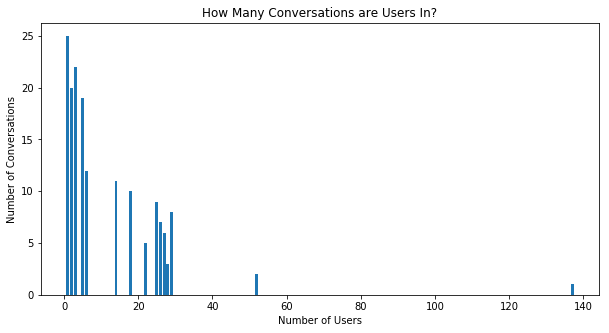

There are very few people in many conversations, and many people in few (1) conversation


In [9]:
# There are more conversations than people, so some people must be in multiple conversations.
# What does this breakdown look like?
convos_per_person = {}
for u in users:
    num_convos = len(users[u]['conversations'])
    if num_convos not in convos_per_person.keys():
        convos_per_person[num_convos] = 0
    convos_per_person[num_convos] += 1

to_sort = np.argsort(list(convos_per_person.values()))
num_convos_sorted = np.array(list(convos_per_person.keys()))[to_sort]
num_ppl_sorted = np.array(list(convos_per_person.values()))[to_sort]

# Plot the results - how many conversations are users in?
plt.figure(figsize=(10, 5))
plt.bar(num_ppl_sorted, num_convos_sorted)
plt.xlabel('Number of Users')
plt.ylabel('Number of Conversations')
plt.title('How Many Conversations are Users In?')
plt.show()

print('There are very few people in many conversations, and many people in few (1) conversation')

#### In our data, what is the distribution of user sex, dialect, age, and education levels?

53.0% of the users are male, and 47.0% are female



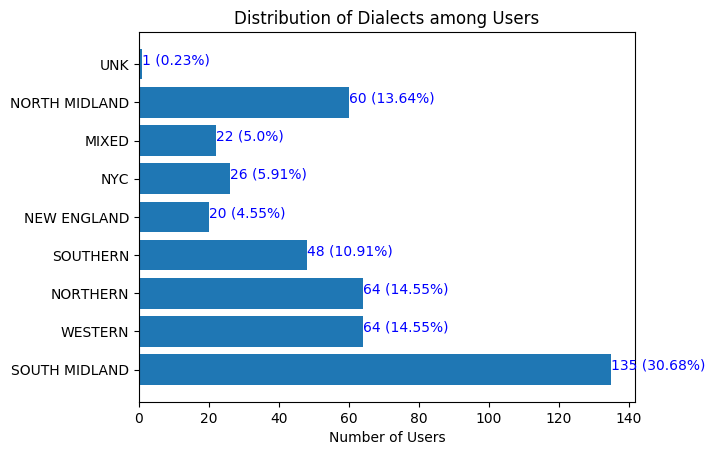

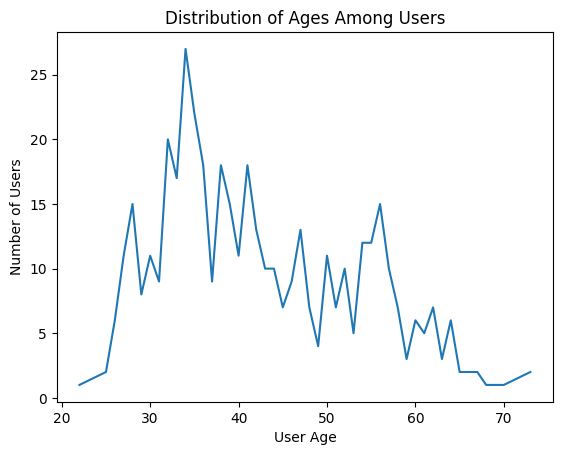

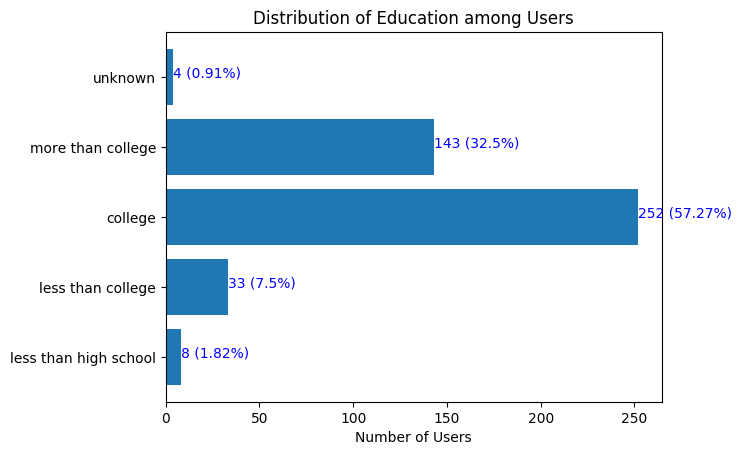

In [10]:
# What is the breakdown of user stats? i.e. distribution of sex, dialect, age?

female = 0
male = 0
dialects = {}
ages = {}
edu = {0:0, 1:0, 2:0, 3:0, 9:0}
for u in users.keys():
    # Count num male and female
    if users[u]['sex'] == 'FEMALE':
        female += 1
    else:
        male += 1
        
    # Count user dialects
    if users[u]['dialect_area'] not in dialects:
        dialects[users[u]['dialect_area']] = 0
    dialects[users[u]['dialect_area']] += 1
    
    # Count user ages (at 1997)
    age = 1997 - users[u]['birth_year']
    if age not in ages:
        ages[age] = 0
    ages[age] += 1
    
    # Count education levels
    edu[users[u]['education']] += 1        
        
print('{0:0.1f}% of the users are male, and {1:0.1f}% are female\n'.format(100*male/len(users), 100*female/len(users)))

# Plot distribution of dialects
plt.rcdefaults()
fig, ax = plt.subplots()    

plt.barh(range(9), list(dialects.values()), align='center')
plt.yticks(range(9),dialects.keys())
for i, v in enumerate(list(dialects.values())):
    ax.text(v, i, str(v)+' ('+str(round(100*v/len(users),2))+'%)', color='blue')
plt.title('Distribution of Dialects among Users')
plt.xlabel('Number of Users')
plt.show()


# Plot distribution of ages (This dataset was collected in 1997 so all ages are from that year)

keys = np.array(list(ages.keys()))
values = np.array(list(ages.values()))
to_sort = np.argsort(keys)

fig, ax = plt.subplots()    
plt.plot(keys[to_sort], values[to_sort])
plt.xlabel('User Age')
plt.ylabel('Number of Users')
plt.title('Distribution of Ages Among Users')
plt.show()

# Plot distribution of education levels
plt.rcdefaults()
fig, ax = plt.subplots()    

plt.barh(range(5), list(edu.values()), align='center')
plt.yticks(range(5), ['less than high school','less than college', 'college', 'more than college', 'unknown'])
for i, v in enumerate(list(edu.values())):
    ax.text(v, i, str(v)+' ('+str(round(100*v/len(users),2))+'%)', color='blue')
plt.title('Distribution of Education among Users')
plt.xlabel('Number of Users')
plt.show()


#### What is the breakdown of a typical conversation? 
* How many utterances do people speak at a time on average?
* How much of the conversation are User A and User B each talking?

In [11]:
total_utt = 0
total_groupings = 0
utt = 0
max_utt = 0
cur_user = ''
cur_convo_id = ''

for i, u in enumerate(corpus.utterances):
    if i == 0:    # first utterance 
        cur_user = corpus.utterances[u].user.name
        cur_convo_id = corpus.utterances[u].root
        utt = 1
    
    elif cur_user != corpus.utterances[u].user.name or cur_convo_id != corpus.utterances[u].root:
        # if new speaker, restart count
        total_utt += utt
        total_groupings += 1
        max_utt = max(utt, max_utt)
        cur_user = corpus.utterances[u].user.name
        cur_convo_id = corpus.utterances[u].root
        utt = 1
        
    else:
        # continuing their speech:
        utt += 1

print('Total number of utterances:', total_utt)
print('Total number of groupings of utterance by speaker:', total_groupings)
print('Average number of utterances a person makes in a row:', total_utt/total_groupings)
print('Max number of utterances a person says in a row:', max_utt)

Total number of utterances: 122645
Total number of groupings of utterance by speaker: 122645
Average number of utterances a person makes in a row: 1.0
Max number of utterances a person says in a row: 1


In [12]:
# In an average conversation, what is the % breakdown of speaking between users by number of tokens? 

user_1 = ''
user_2 = ''
user_1_tokens = 0
user_2_tokens = 0
cur_convo_id = ''
total_tokens = 0
tokenizer = RegexpTokenizer(r'\w+')

for i, u in enumerate(corpus.utterances):
    tokens = tokenizer.tokenize(corpus.utterances[u].text)
    
    if corpus.utterances[u].root != cur_convo_id:
        # new conversation
        user_1 = corpus.utterances[u].user.name  # user 1 is first person to speak 
        cur_convo_id = corpus.utterances[u].root 
        
    if corpus.utterances[u].user.name == user_1:
        user_1_tokens += len(tokens)
    else:
        user_2_tokens += len(tokens)
    total_tokens += len(tokens)
    
print('User 1 speaks {0:0.1f}% of tokens and User 2 speaks {1:0.1f}% of tokens'
      .format(100*user_1_tokens/total_tokens, 100*user_2_tokens/total_tokens))
print('There are on average {0:0.2f} tokens per conversation and {1:0.2f} tokens per utterance.'
      .format(total_tokens/len(corpus.meta['metadata']), total_tokens/len(corpus.utterances)))

User 1 speaks 51.8% of tokens and User 2 speaks 48.2% of tokens
There are on average 1464.17 tokens per conversation and 13.79 tokens per utterance.


Conversation Metadata keys: dict_keys([])
Each conversation is on average 6.57 minutes
There are 66 total conversation topics, broken down as follows:


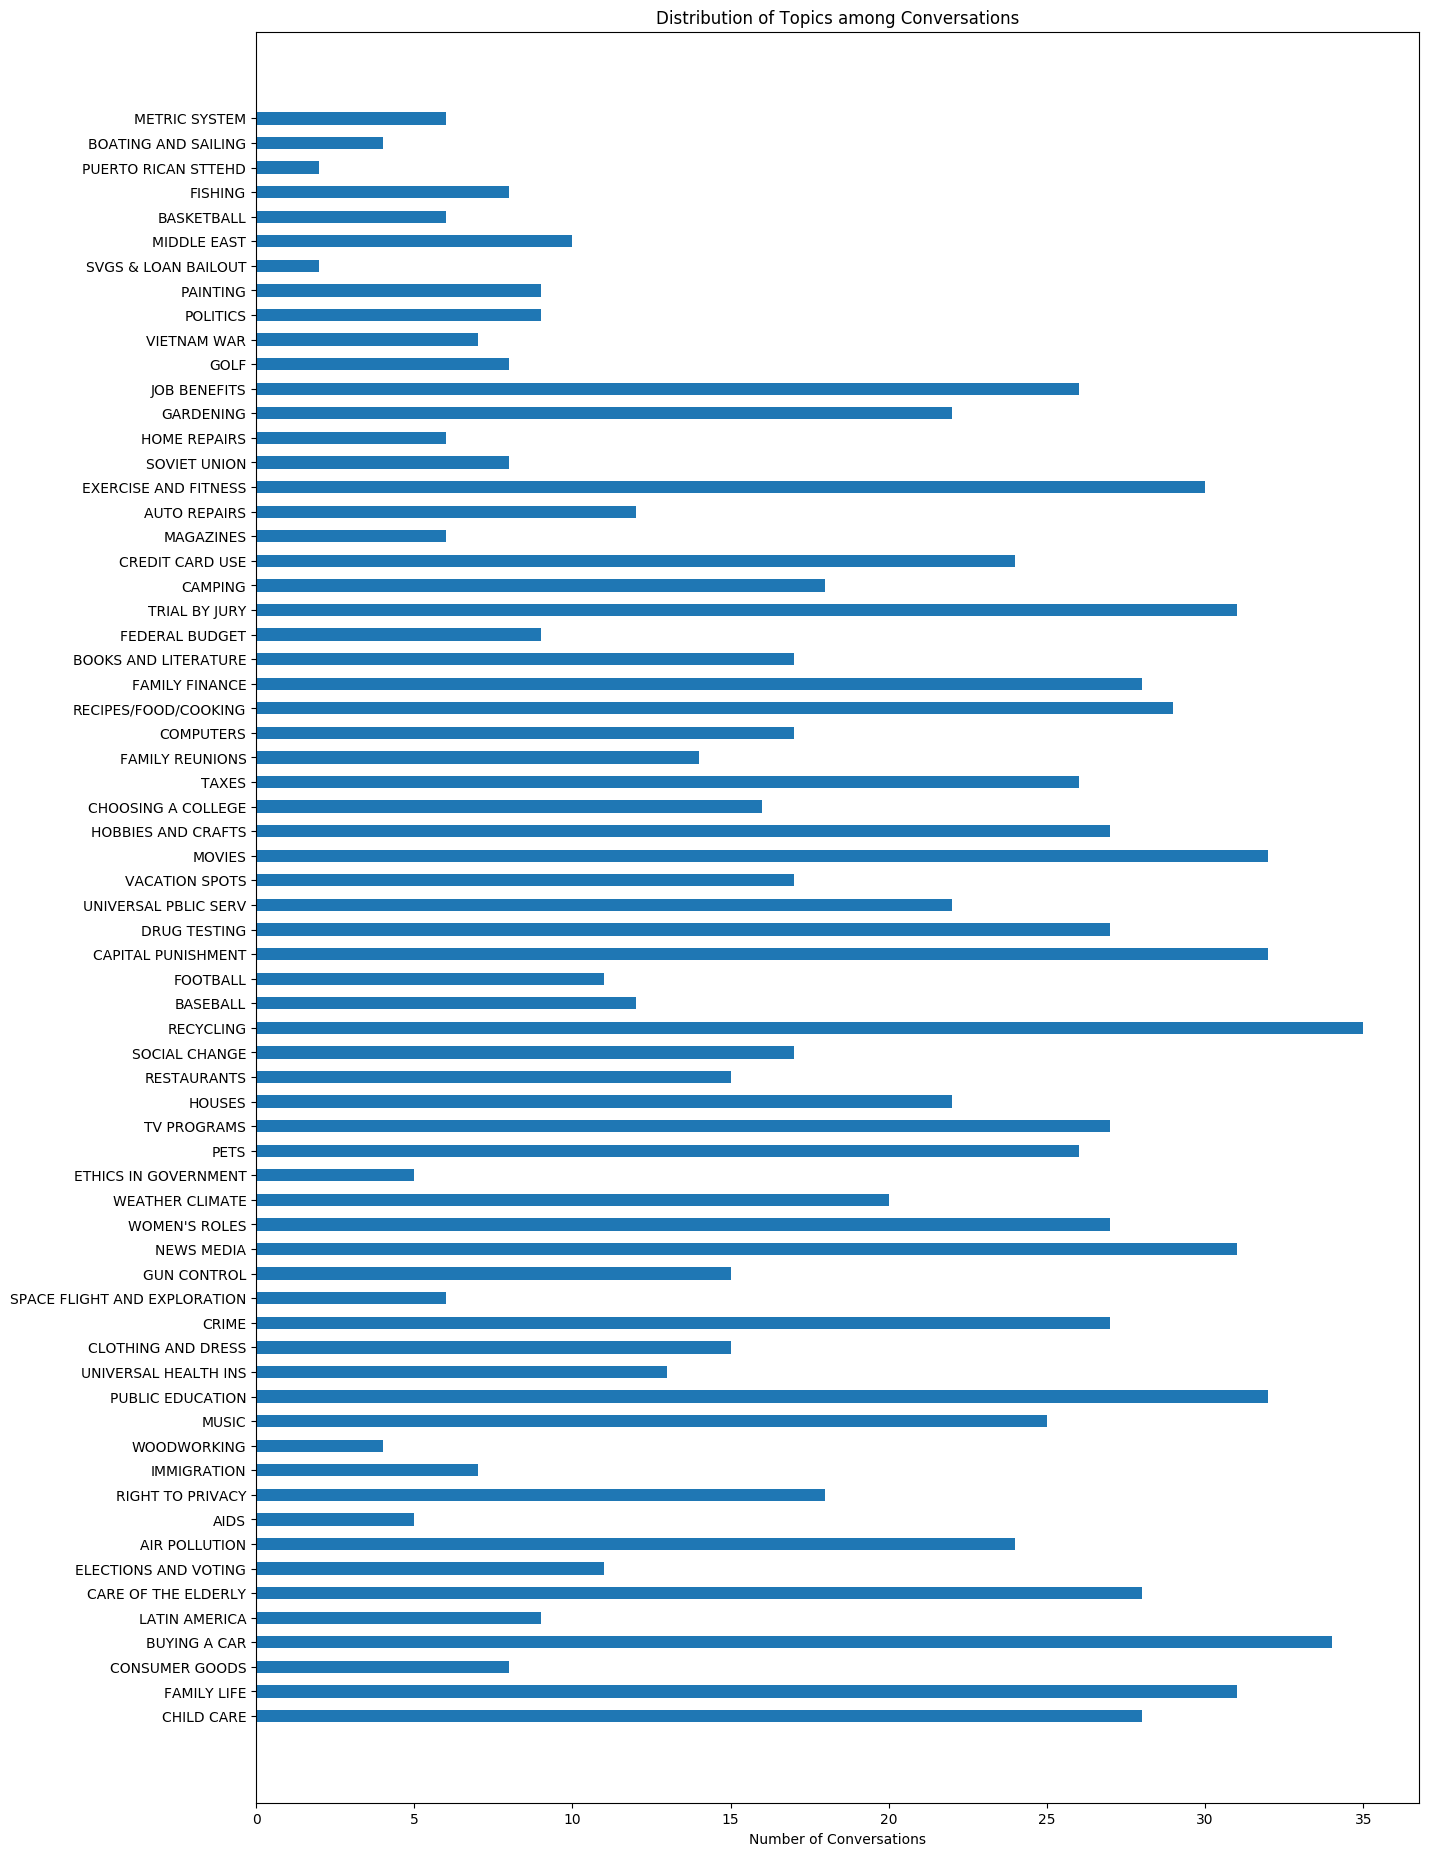

In [13]:
# What is the breakdown of conversation topics/prompts? What is the average length of a conversation?

print('Conversation Metadata keys:', corpus.meta['metadata']['4109'].keys())

topics = {}
lengths = []
for convo in corpus.iter_conversations():
    topic = convo.meta['topic_description']
    if topic not in topics:
        topics[topic] = 0
    topics[topic] += 1
    
    lengths.append(convo.meta['length'])

print('Each conversation is on average {0:0.2f} minutes'.format(sum(lengths)/len(lengths)))

print('There are {} total conversation topics, broken down as follows:'.format(len(topics)))

# Plot topic distribution:
# fig, ax = plt.subplots()    
plt.figure(figsize=(15, 23))  # width:20, height:3

plt.barh(range(len(topics)), list(topics.values()), align='center', height=.5)
plt.yticks(range(len(topics)), list(topics.keys()))
for i, v in enumerate(list(topics.values())):
    ax.text(v, i, str(v)+' ('+str(round(100*v/len(corpus.meta['metadata']),2))+'%)', color='blue')
plt.title('Distribution of Topics among Conversations')
plt.xlabel('Number of Conversations')
plt.show()
